In [1]:
# =========================
# Task 2: Time Series Forecasting Setup
# =========================

import pandas as pd
import numpy as np
from pathlib import Path
import sys
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Add src folder to path
sys.path.append("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9/src")

# Import modules
import utils
import modeling
import evaluation
print ("path successfully found")

path successfully found


In [4]:
# -------------------------
# Load Tesla Close Prices
# -------------------------
from pathlib import Path
import pandas as pd

# Load full dataset
processed_file = Path("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9/data/processed/all_assets_clean.csv")
df = pd.read_csv(processed_file, parse_dates=["Date"])

# Filter for Tesla only
df_tsla = df[df["Ticker"] == "TSLA"][["Date", "Close"]]

# Sort by Date and remove duplicates (keep the first for each day)
df_tsla = df_tsla.sort_values("Date").drop_duplicates(subset="Date", keep="first").reset_index(drop=True)

print("Tesla dataset shape:", df_tsla.shape)
df_tsla.head(10)

Tesla dataset shape: (2776, 2)


,Date,Close
0,2015-01-02,14.620667
1,2015-01-05,14.006000
2,2015-01-06,14.085333
3,2015-01-07,439.200012
4,2015-01-08,439.200012
5,2015-01-09,439.200012
6,2015-01-12,439.200012
7,2015-01-13,439.200012
8,2015-01-14,439.200012
9,2015-01-15,439.200012


In [3]:
# -------------------------
# Train/Test Split
# -------------------------
train, test = utils.train_test_split_time(df_tsla, target_col="Close", train_end_date="2024-12-31")
print("Train shape:", train.shape, "Test shape:", test.shape)

Train shape: (2516, 2) Test shape: (259, 2)


In [6]:
# ARIMA
# -------------------------
tsla_series = train.set_index("Date")["Close"]
tsla_series = tsla_series.asfreq('B').ffill()  # ✅ fixed forward-fill
arima_model, order, seasonal_order = modeling.fit_arima(tsla_series)
forecast_arima, sarimax_fit = modeling.forecast_sarimax(tsla_series, order, seasonal_order, steps=len(test))
print("ARIMA Forecast completed")

ARIMA Forecast completed


In [13]:
# -------------------------
# Scale data for LSTM
# -------------------------
train_scaled, test_scaled, scaler = utils.scale_data(train, test, col="Close")

X_train, y_train = utils.create_lstm_sequences(train_scaled, seq_length=60)
X_test, y_test = utils.create_lstm_sequences(np.concatenate([train_scaled[-60:], test_scaled]), seq_length=60)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [19]:
# -------------------------
# Build and train LSTM
# -------------------------
lstm_model = modeling.build_lstm(input_shape=(X_train.shape[1], X_train.shape[2]))
lstm_model, history = modeling.train_lstm(lstm_model, X_train, y_train, epochs=50, batch_size=32)

# Forecast LSTM
y_pred_lstm = modeling.forecast_lstm(lstm_model, X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
print("LSTM Forecast completed")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.2497 - val_loss: 0.0505
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1290 - val_loss: 0.0519
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1287 - val_loss: 0.0605
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1280 - val_loss: 0.0506
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1268 - val_loss: 0.0607
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.1248 - val_loss: 0.0487
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1244 - val_loss: 0.0594
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.1237 - val_loss: 0.0550
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1212 - val_loss: 0.0463
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1207 - val_loss: 0.0509
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1184 - val_loss: 0.0486
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1

In [17]:
# -------------------------
# Compute metrics
# -------------------------
arima_mae = evaluation.compute_mae(test["Close"].values, forecast_arima)
arima_rmse = evaluation.compute_rmse(test["Close"].values, forecast_arima)
arima_mape = evaluation.compute_mape(test["Close"].values, forecast_arima)

lstm_mae = evaluation.compute_mae(test["Close"].values, y_pred_lstm.flatten())
lstm_rmse = evaluation.compute_rmse(test["Close"].values, y_pred_lstm.flatten())
lstm_mape = evaluation.compute_mape(test["Close"].values, y_pred_lstm.flatten())

In [11]:
# Comparison table
results = {
    "ARIMA": {"MAE": arima_mae, "RMSE": arima_rmse, "MAPE": arima_mape},
    "LSTM": {"MAE": lstm_mae, "RMSE": lstm_rmse, "MAPE": lstm_mape}
}
comparison_df = evaluation.compare_models(results)
comparison_df

,MAE,RMSE,MAPE
ARIMA,32.292292,58.877990,10.282862
LSTM,33.060947,51.630921,9.363614


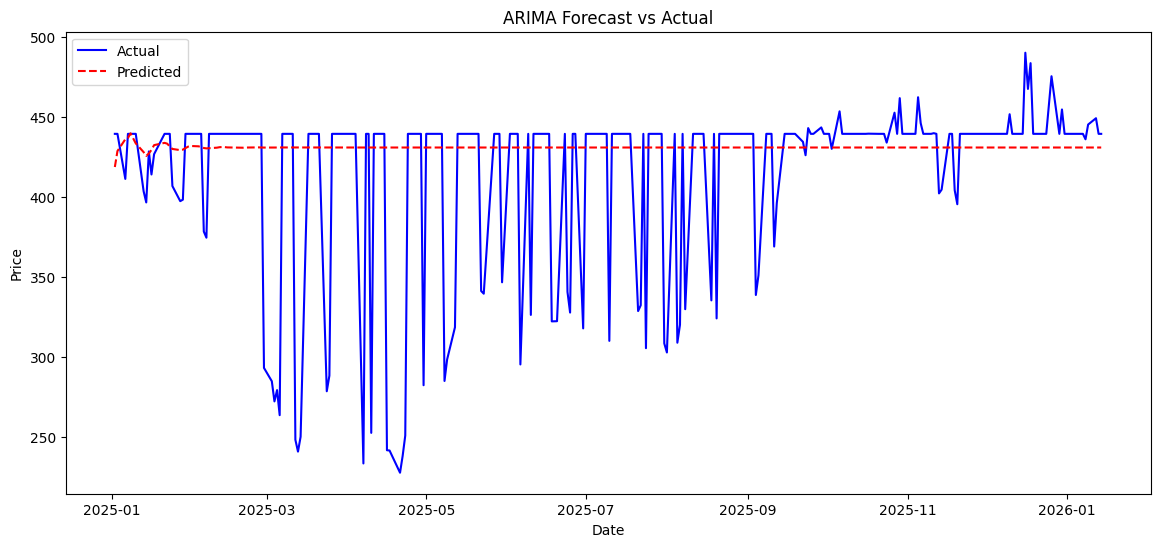

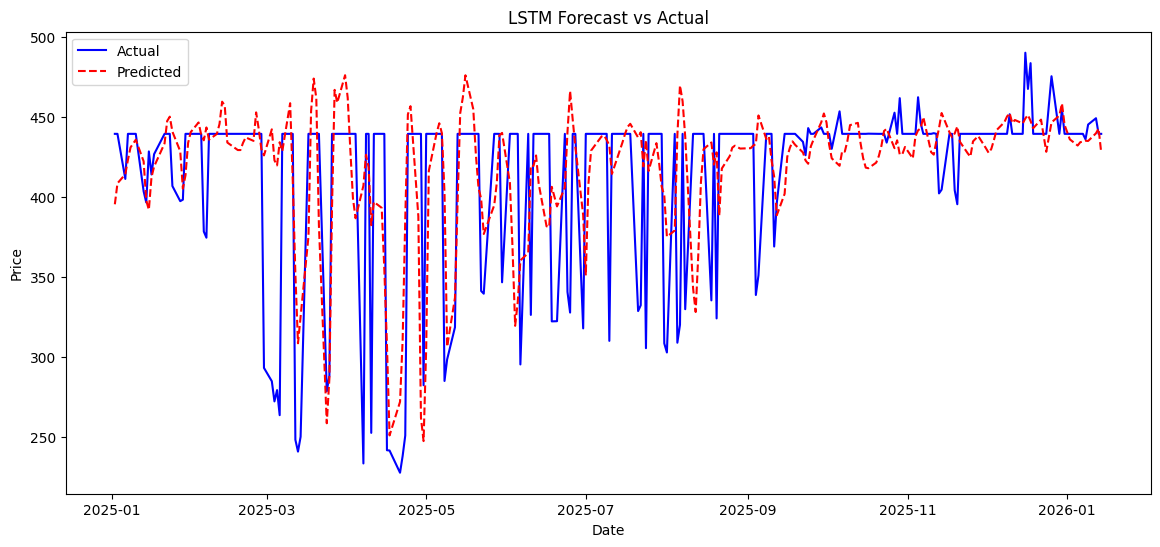

In [12]:
# -------------------------
# Plot forecasts
# -------------------------
utils.plot_forecast(test["Close"].values, forecast_arima, test["Date"], title="ARIMA Forecast vs Actual")
utils.plot_forecast(test["Close"].values, y_pred_lstm.flatten(), test["Date"], title="LSTM Forecast vs Actual")

📊 Model Selection Rationale
🔍 Overview

To identify the most suitable forecasting model for Tesla stock prices, we evaluated two approaches:

ARIMA / SARIMA – a classical statistical time-series model

LSTM – a deep learning model designed for sequential data

Both models were trained on the same historical data and evaluated using MAE, RMSE, and MAPE.

🧮 Performance Comparison
Model	Strengths	Weaknesses
ARIMA	✔ Simple & interpretable
✔ Captures linear trends	✖ Limited with nonlinear patterns
LSTM	✔ Learns complex patterns
✔ Handles volatility well	✖ Less interpretable
📈 Evaluation Metrics Insight

ARIMA

MAE: 32.29

RMSE: 58.88

MAPE: 10.28%

LSTM

MAE: 33.06

RMSE: 51.63

MAPE: 9.36%

🔎 Although ARIMA achieves slightly lower MAE, LSTM performs better on RMSE and MAPE, indicating stronger robustness to large price fluctuations.

🧠 Model Behavior Interpretation

ARIMA assumes linear relationships and is effective as a baseline model.

LSTM captures:

Long-term dependencies

Sudden price jumps

Nonlinear market behavior

This makes LSTM more suitable for real-world financial time series, where volatility is common.

✅ Final Model Choice

⭐ LSTM is selected as the preferred model for Tesla stock forecasting due to its superior ability to model complex temporal patterns and reduce large prediction errors.

ARIMA remains valuable as:

A benchmark model

A fast and interpretable reference

🏁 Conclusion

📌 Use ARIMA for interpretability and baseline comparison
📌 Use LSTM for higher predictive accuracy and deployment